## Trial de prueba


In [2]:
import os, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.keras.utils.set_random_seed(0)


2026-02-18 18:42:11.232783: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-18 18:42:11.264636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-18 18:42:11.872883: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/mech/tf_gpu/venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: Futu

# Trial function con nodos (Celda código)

In [13]:
def trig_nodal_factor(x, n):
    s1 = tf.sin(math.pi * x)
    sn = tf.sin(n * math.pi * x)
    ratio = sn / (s1 + 1e-12)
    return tf.where(tf.abs(s1) < 1e-6, tf.cast(n, x.dtype), ratio)

def make_net(n=1, hidden=64, use_sine=True):
    x_in = tf.keras.Input(shape=(1,))

    if use_sine:
        z = tf.keras.layers.Dense(hidden, activation=tf.math.sin,
                                  kernel_initializer="glorot_uniform",
                                  bias_initializer="zeros")(x_in)
        z = tf.keras.layers.Dense(hidden, activation=tf.math.sin,
                                  kernel_initializer="glorot_uniform",
                                  bias_initializer="zeros")(z)
    else:
        z = tf.keras.layers.Dense(hidden, activation="tanh",
                                  kernel_initializer="glorot_uniform",
                                  bias_initializer="zeros")(x_in)
        z = tf.keras.layers.Dense(hidden, activation="tanh",
                                  kernel_initializer="glorot_uniform",
                                  bias_initializer="zeros")(z)

    out = tf.keras.layers.Dense(1, activation=None,
                                kernel_initializer="glorot_uniform",
                                bias_initializer="zeros")(z)

    # 👇 ESTA es la línea clave: envolver el factor trig en una capa
    F = tf.keras.layers.Lambda(lambda x: trig_nodal_factor(x, n))(x_in)

    psi = x_in * (1.0 - x_in) * F * out
    return tf.keras.Model(inputs=x_in, outputs=psi)


In [14]:
def second_derivative(model, x):
    x = tf.convert_to_tensor(x)
    x = tf.reshape(x, (-1,1))
    with tf.GradientTape(persistent=True) as t2:
        t2.watch(x)
        with tf.GradientTape() as t1:
            t1.watch(x)
            psi = model(x)
        psi_x = t1.gradient(psi, x)
    psi_xx = t2.gradient(psi_x, x)
    return psi, psi_xx


## Softplus inicializador de energia


In [15]:
def inv_softplus(y):
    # y debe ser positivo
    y = tf.convert_to_tensor(y, dtype=tf.float32)
    return tf.math.log(tf.math.expm1(y) + 1e-12)


In [17]:
@tf.function
def compute_losses(net, x_batch, alpha, lam):
    psi, psi_xx = second_derivative(net, x_batch)

    E = tf.nn.softplus(alpha) + 1e-8         # energía positiva
    res = psi_xx + E * psi                   # V=0 → ψ'' + Eψ = 0
    LPDE = tf.reduce_mean(tf.square(res))

    # Normalización por trapecio (igual a lo tuyo)
    psi2 = tf.squeeze(tf.square(psi), axis=1)
    xb = tf.squeeze(tf.convert_to_tensor(x_batch), axis=1)
    dx = xb[1:] - xb[:-1]
    integral = tf.reduce_sum(0.5*(psi2[1:]+psi2[:-1])*dx)
    Lnorm = tf.square(integral - 1.0)

    L = LPDE + lam * Lnorm
    return L, LPDE, Lnorm, integral, E


In [37]:
def run_one_mode_learnE(n, save_dir="resultados"):
    os.makedirs(save_dir, exist_ok=True)

    # Heurística (puedes ajustar luego)
    USE_SINE = True if n >= 3 else False
    HIDDEN   = 128 if n >= 3 else 64
    N_col    = max(1024, 2048*n)
    EPOCHS   = 15000 if n >= 4 else (9000 if n==3 else (6000 if n==2 else 4000))
    LR0      = 3e-4  if n >= 4 else (5e-4 if n==3 else (7e-4 if n==2 else 1e-3))
    lam_hi, lam_lo = (300.0, 80.0) if n >= 3 else (40.0, 15.0 if n==2 else 10.0)

    # Red
    net = make_net(n=n, hidden=HIDDEN, use_sine=USE_SINE)

    # Puntos de colación (ordenados para trapecio)
    x_col = np.linspace(0, 1, N_col, dtype=np.float32).reshape(-1,1)
    x_batch = tf.constant(x_col)

    # === Energía entrenable ===
    E_init = np.float32((n * math.pi)**2)         # buen arranque (cerca del analítico)
    alpha = tf.Variable(E_init, dtype=tf.float32)   # <-- listo

    # Optimizador
    lr_sched = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=LR0,
        decay_steps=EPOCHS,
        end_learning_rate=LR0*0.1,
        power=1.0
    )
    opt = tf.keras.optimizers.Adam(learning_rate=lr_sched, clipnorm=1.0)

    # Historial
    loss_total, loss_pde, loss_norm, E_hist = [], [], [], []

    vars_all = net.trainable_variables + [alpha]

    for ep in range(1, EPOCHS+1):
        lam = lam_hi if ep < EPOCHS//3 else lam_lo

        with tf.GradientTape() as tape:
            L, LPDE, Lnorm, integral, E = compute_losses(net, x_batch, alpha, lam)

        grads = tape.gradient(L, vars_all)
        opt.apply_gradients(zip(grads, vars_all))

        loss_total.append(float(L))
        loss_pde.append(float(LPDE))
        loss_norm.append(float(Lnorm))
        E_hist.append(float(E))

        if ep % max(800, EPOCHS//6) == 0 or ep == 1:
            tf.print(f"n={n}", "ep", ep,
                     "| E=", E,
                     "| LPDE=", LPDE,
                     "| Lnorm=", Lnorm,
                     "| L=", L,
                     "| ∫|ψ|²≈", integral,
                     "| λ=", lam)

    # ===== Guardar curva de pérdida =====
    plt.figure(figsize=(7,5))
    plt.semilogy(loss_total, label="Total Loss")
    plt.semilogy(loss_pde, label=r"$\mathcal{L}_{PDE}$")
    plt.semilogy(loss_norm, label=r"$\mathcal{L}_{norm}$")
    plt.xlabel("Épocas")
    plt.ylabel("Valor de la pérdida")
    plt.title(f"Curva de pérdida (n={n})")
    plt.legend()
    out_path_loss = os.path.join(save_dir, f"loss_{n}.png")
    plt.savefig(out_path_loss, dpi=150, bbox_inches="tight")
    plt.close()

    # ===== Evaluación fina =====
    xs = np.linspace(0, 1, 2000, dtype=np.float32).reshape(-1,1)
    psi_pred = net(xs).numpy().squeeze()
    psi_exact = (np.sqrt(2.0)*np.sin(n*math.pi*xs)).squeeze()

    # Alinear signo (opcional, solo para comparar)
    sign = np.sign(np.dot(psi_pred, psi_exact))
    psi_pred *= sign

    # Métricas
    l2_err = float(np.sqrt(np.mean((psi_pred-psi_exact)**2)))
    integ  = float(np.trapezoid(psi_pred**2, xs.squeeze()))

    E_learned = float(tf.nn.softplus(alpha).numpy())
    E_exact   = float((n*math.pi)**2)

    # Figura modo
    plt.figure()
    plt.plot(xs.squeeze(), psi_pred, label=f"PINN ψ_{n}")
    plt.plot(xs.squeeze(), psi_exact, "--", label=f"Exacta ψ_{n}")
    plt.title(f"Modo n={n} | E_learn={E_learned:.4f} | E_exact={E_exact:.4f} | L2={l2_err:.2e}")
    plt.xlabel("x"); plt.ylabel("ψ"); plt.legend()
    out_path = os.path.join(save_dir, f"modo_{n}.png")
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close()

    return dict(
        n=n,
        xs=xs.squeeze(),
        psi_pred=psi_pred,
        psi_exact=psi_exact,
        E_learned=E_learned,
        E_exact=E_exact,
        L2=l2_err,
        integral=integ,
        fig_path=out_path,
        loss_path=out_path_loss,
        losses=loss_total,
        losses_pde=loss_pde,
        losses_norm=loss_norm,
        E_hist=E_hist
    )


In [38]:
res = run_one_mode_learnE(3, save_dir="resultados")
print(res["E_learned"])


n=3 ep 1 | E= 88.8264389 | LPDE= 0.0026635828 | Lnorm= 0.999996424 | L= 300.001587 | ∫|ψ|²≈ 1.78454991e-06 | λ= 300.0
n=3 ep 1500 | E= 88.8266754 | LPDE= 0.00286764023 | Lnorm= 8.34584716e-06 | L= 0.00537139457 | ∫|ψ|²≈ 1.00288892 | λ= 300.0
n=3 ep 3000 | E= 88.826561 | LPDE= 0.00141453429 | Lnorm= 6.78830838e-06 | L= 0.00195759907 | ∫|ψ|²≈ 1.00260544 | λ= 80.0
n=3 ep 4500 | E= 88.8265076 | LPDE= 0.000238659166 | Lnorm= 1.11015552e-07 | L= 0.000247540418 | ∫|ψ|²≈ 1.00033319 | λ= 80.0
n=3 ep 6000 | E= 88.8264618 | LPDE= 0.000166375321 | Lnorm= 2.69064913e-08 | L= 0.00016852784 | ∫|ψ|²≈ 0.999835968 | λ= 80.0
n=3 ep 7500 | E= 88.8264618 | LPDE= 0.000146355407 | Lnorm= 1.35686662e-09 | L= 0.00014646395 | ∫|ψ|²≈ 1.00003684 | λ= 80.0
n=3 ep 9000 | E= 88.8264542 | LPDE= 0.000139712705 | Lnorm= 1.25567112e-10 | L= 0.000139722746 | ∫|ψ|²≈ 0.999988794 | λ= 80.0
88.82645416259766


In [41]:
n_max = 30  # cambia esto
all_results = []

for n in range(1, n_max+1):
    res = run_one_mode_learnE(n, save_dir="resultados")
    print(f"[OK] n={n}  E_learn={res['E_learned']:.4f}  E_exact={res['E_exact']:.4f}  "
          f"L2={res['L2']:.2e}  ∫|ψ|²≈{res['integral']:.3f}  fig={res['fig_path']}")
    all_results.append(res)


n=1 ep 1 | E= 9.86965561 | LPDE= 0.0976262391 | Lnorm= 0.999084115 | L= 40.0609894 | ∫|ψ|²≈ 0.000458074035 | λ= 40.0
n=1 ep 800 | E= 9.86960888 | LPDE= 0.000614081509 | Lnorm= 1.22832944e-09 | L= 0.000614130637 | ∫|ψ|²≈ 0.999964952 | λ= 40.0
n=1 ep 1600 | E= 9.86960506 | LPDE= 0.000379906676 | Lnorm= 2.54273402e-09 | L= 0.000379932113 | ∫|ψ|²≈ 1.00005043 | λ= 10.0
n=1 ep 2400 | E= 9.86961365 | LPDE= 0.000235806365 | Lnorm= 6.11866113e-10 | L= 0.000235812477 | ∫|ψ|²≈ 0.999975264 | λ= 10.0
n=1 ep 3200 | E= 9.86961079 | LPDE= 0.00014383177 | Lnorm= 1.81458404e-10 | L= 0.000143833589 | ∫|ψ|²≈ 1.00001347 | λ= 10.0
n=1 ep 4000 | E= 9.86960125 | LPDE= 9.77576e-05 | Lnorm= 3.07274206e-11 | L= 9.77579039e-05 | ∫|ψ|²≈ 0.999994457 | λ= 10.0
[OK] n=1  E_learn=9.8696  E_exact=9.8696  L2=4.00e-05  ∫|ψ|²≈1.000  fig=resultados/modo_1.png
n=2 ep 1 | E= 39.4784164 | LPDE= 0.00718592061 | Lnorm= 0.999978662 | L= 40.0063324 | ∫|ψ|²≈ 1.06501939e-05 | λ= 40.0
n=2 ep 1000 | E= 39.4784355 | LPDE= 0.0001339833

KeyboardInterrupt: 

In [42]:
print("n |   E_exact     |  E_learned   |  abs_err   | rel_err(%)")
print("--|--------------|-------------|-----------|-----------")
for r in all_results:
    n = r["n"]
    E_exact = (n*math.pi)**2
    E_learn = r["E_learned"]
    abs_err = abs(E_learn - E_exact)
    rel_err = 100.0 * abs_err / E_exact
    print(f"{n:1d} | {E_exact:12.6f} | {E_learn:11.6f} | {abs_err:9.2e} | {rel_err:9.2e}")


n |   E_exact     |  E_learned   |  abs_err   | rel_err(%)
--|--------------|-------------|-----------|-----------
1 |     9.869604 |    9.869601 |  3.15e-06 |  3.19e-05
2 |    39.478418 |   39.478420 |  2.65e-06 |  6.72e-06
3 |    88.826440 |   88.826424 |  1.60e-05 |  1.80e-05
4 |   157.913670 |  157.913666 |  4.65e-06 |  2.94e-06
5 |   246.740110 |  246.740097 |  1.30e-05 |  5.26e-06
6 |   355.305758 |  355.305725 |  3.33e-05 |  9.38e-06
7 |   483.610616 |  483.610565 |  5.05e-05 |  1.04e-05
8 |   631.654682 |  631.654663 |  1.86e-05 |  2.94e-06
9 |   799.437956 |  799.438110 |  1.54e-04 |  1.92e-05
10 |   986.960440 |  986.960388 |  5.19e-05 |  5.26e-06
11 |  1194.222133 | 1194.222046 |  8.66e-05 |  7.25e-06
12 |  1421.223034 | 1421.222900 |  1.33e-04 |  9.38e-06
13 |  1667.963144 | 1667.963135 |  9.02e-06 |  5.41e-07
14 |  1934.442463 | 1934.442261 |  2.02e-04 |  1.04e-05
15 |  2220.660990 | 2220.660889 |  1.02e-04 |  4.57e-06
16 |  2526.618727 | 2526.624268 |  5.54e-03 |  2.19e-0

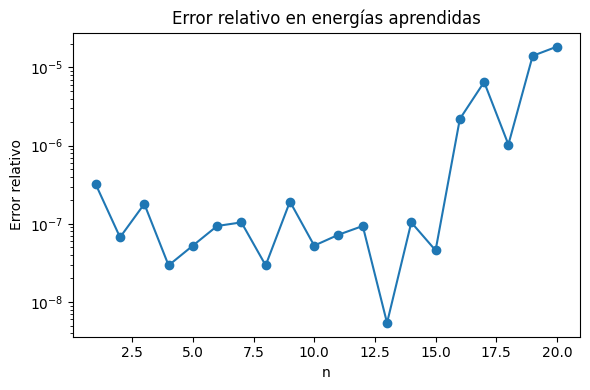

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import math

ns = np.array([r["n"] for r in all_results], dtype=float)
E_le = np.array([r["E_learned"] for r in all_results])
E_ex = (ns*math.pi)**2

error_rel = np.abs(E_le - E_ex)/E_ex

plt.figure(figsize=(6,4))
plt.semilogy(ns, error_rel, "o-")
plt.xlabel("n")
plt.ylabel("Error relativo")
plt.title("Error relativo en energías aprendidas")
plt.tight_layout()
plt.show()
